In [1]:
import xpress as xp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyreadr import read_r
from scipy.interpolate import interp1d
from param_watervalues import Reservoir
from time import time

In [2]:
%load_ext line_profiler

In [3]:
%matplotlib widget

In [4]:
xp.controls.outputlog = -1

In [5]:
study_path = "D:/Users/gerbauxjul/Documents/6-Etudes Antares/ERAA_scandinavie"
output_path = study_path+"/user/fast_fi00"

In [6]:
def retrieve_problem(year,week,output_path,itr=1):
    model = xp.problem()
    model.read(output_path+f"/problem-{year}-{week}--optim-nb-{itr}.mps")
    return(model)

In [7]:
S = 52
NTrain = 1
H = 168

In [8]:
def create_weekly_problem_itr(k,s,output_path):
    model = retrieve_problem(k+1,s+1,output_path)
    model.controls.xslp_log = -1

    cst = model.getConstraint()
    binding_id = [i for i in range(len(cst)) if "WeeklyWaterAmount" in cst[i].name]

    return([model,binding_id])
    

In [9]:
def modify_weekly_problem_itr(model,binding_id,u):

    model.chgrhs(binding_id,[u])

    model.lpoptimize()

    if model.attributes.lpstatus==1:
        beta = model.getObjVal()
        lamb = model.getDual(binding_id)[0]
        return(beta,lamb,model.attributes.SIMPLEXITER)
    else :
        raise(ValueError)

In [10]:
def calculate_VU(reward, reservoir,X,U, pen_low, pen_high):
    V = np.zeros((len(X), S+1))

    for s in range(S-1,-1,-1):#
        V_fut = interp1d(X, V[:, s+1])
        pen = interp1d([0,reservoir.Xmin[s],reservoir.Xmax[s],reservoir.capacity],[-pen_low*(reservoir.Xmin[s]),0,0,-pen_high*(reservoir.capacity-reservoir.Xmax[s])])

        for k in range(NTrain):
            Gs = lambda x: min([reward[i][s,0]*x+reward[i][s,1] for i in range(len(reward))])
            for i in range(len(X)):
                Vu = float('-inf')

                for i_fut in range(len(X)):
                    u = -X[i_fut] + X[i] + reservoir.inflow[s,k]*H
                    if -reservoir.P_pump[7*s]*H <= u <= reservoir.P_turb[7*s]*H:
                        G = Gs(u)
                        penalty = pen(X[i_fut])
                        if (G + V[i_fut, s+1]+penalty) > Vu:
                            Vu = G + V[i_fut, s+1]+penalty

                for u in range(len(U[s])):
                    state_fut = min(reservoir.capacity,X[i] - U[s][u] + reservoir.inflow[s,k]*H) 
                    if 0 <= state_fut :
                        penalty = pen(state_fut)
                        G = Gs(U[s][u])
                        if (G + V_fut(state_fut)+penalty) > Vu:
                            Vu = (G + V_fut(state_fut)+penalty)

                Umin = X[i]+ reservoir.inflow[s,k]*H-reservoir.Xmin[s]
                if -reservoir.P_pump[7*s]*H <= Umin <= reservoir.P_turb[7*s]*H:
                    state_fut = X[i] - Umin + reservoir.inflow[s,k]*H
                    penalty = pen(state_fut)
                    if (Gs(Umin) + V_fut(state_fut)+penalty) > Vu:
                        Vu = Gs(Umin) + V_fut(state_fut)+penalty

                Umax = X[i]+ reservoir.inflow[s,k]*H-reservoir.Xmax[s]
                if -reservoir.P_pump[7*s]*H <= Umax <= reservoir.P_turb[7*s]*H:
                    state_fut = X[i] - Umax + reservoir.inflow[s,k]*H 
                    penalty = pen(state_fut)
                    if (Gs(Umax) + V_fut(state_fut)+penalty) > Vu:
                        Vu = Gs(Umax) + V_fut(state_fut)+penalty
            
                V[i, s] = Vu/NTrain + V[i,s]
    return V

In [11]:
def compute_x(reservoir,X,U,V,reward,pen_low,pen_high):
    initial_x = [reservoir.initial_level]
    k = 0
    cout_tot = 0
    V0 = interp1d(X, V[:, 0])
    V0 = V0(reservoir.initial_level)

    for s in range(S):
        cout = 0
        V_fut = interp1d(X, V[:, s+1])
        pen = interp1d([0,reservoir.Xmin[s],reservoir.Xmax[s],reservoir.capacity],[-pen_low*(reservoir.Xmin[s]),0,0,-pen_high*(reservoir.capacity-reservoir.Xmax[s])])
        Gs = lambda x: min([reward[i][s,0]*x+reward[i][s,1] for i in range(len(reward))])

        Vu = float('-inf')

        for i_fut in range(len(X)):
            u = -X[i_fut] + initial_x[-1] + reservoir.inflow[s,k]*H
            if -reservoir.P_pump[7*s]*H <= u <= reservoir.P_turb[7*s]*H:
                G = Gs(u)
                penalty = pen(X[i_fut])
                if (G + V[i_fut, s+1]+penalty) > Vu:
                    Vu = G + V[i_fut, s+1]+penalty
                    xf = X[i_fut]
                    cout = G

        for u in range(len(U[s])):
            state_fut = min(reservoir.capacity,initial_x[-1] - U[s][u] + reservoir.inflow[s,k]*H) 
            if 0 <= state_fut :
                penalty = pen(state_fut)
                G = Gs(U[s][u])
                if (G + V_fut(state_fut)+penalty) > Vu:
                    Vu = (G + V_fut(state_fut)+penalty)
                    xf = state_fut
                    cout = G

        Umin = initial_x[-1]+ reservoir.inflow[s,k]*H-reservoir.Xmin[s]
        if -reservoir.P_pump[7*s]*H <= Umin <= reservoir.P_turb[7*s]*H:
            state_fut = initial_x[-1] - Umin + reservoir.inflow[s,k]*H
            penalty = pen(state_fut)
            if (Gs(Umin) + V_fut(state_fut)+penalty) > Vu:
                Vu = Gs(Umin) + V_fut(state_fut)+penalty
                xf = state_fut
                cout = Gs(Umin)

        Umax = initial_x[-1]+ reservoir.inflow[s,k]*H-reservoir.Xmax[s]
        if -reservoir.P_pump[7*s]*H <= Umax <= reservoir.P_turb[7*s]*H:
            state_fut = initial_x[-1] - Umax + reservoir.inflow[s,k]*H 
            penalty = pen(state_fut)
            if (Gs(Umax) + V_fut(state_fut)+penalty) > Vu:
                Vu = Gs(Umax) + V_fut(state_fut)+penalty
                xf = state_fut
                cout = Gs(Umax)

        initial_x.append(xf)
        cout_tot += -cout
    return(initial_x, cout_tot,V0)

In [12]:
def itr_control(reservoir:Reservoir, output_path, pen_low, pen_high,X, N):
    
    list_models = []
    for s in range(S):
        m = create_weekly_problem_itr(k=0,s=s,output_path=output_path)
        list_models.append(m)
    
    initial_x = [reservoir.initial_level]
    for s in range(S):
        xf = initial_x[-1] + max(reservoir.inflow[s,0]*H-reservoir.P_turb[7*s]*H,0)
        initial_x.append(xf)

    G = []
    U = [[reservoir.P_turb[7*s]*H,-reservoir.P_pump[7*s]*H] for s in range(S)]

    gap = 1e3
    while gap>=1e-4 or gap<=-1e-4:
        Gj = np.zeros((S+1,2))
        upper_bound = 0
        for s in range(S):
            print(s,end="\r")
            m = list_models[s]
            u = -(initial_x[s+1]-initial_x[s]-reservoir.inflow[s,0]*H)
            beta,lamb,itr = modify_weekly_problem_itr(model=m[0],binding_id=m[1],u=u)
            Gj[s,0] = -lamb
            Gj[s,1] = -beta + lamb*u
            U[s].append(u)
            upper_bound += beta
        G.append(Gj)

        V = calculate_VU(reward=G,reservoir=reservoir,X=X,U=U,pen_low=pen_low,pen_high=pen_high)

        initial_x, lower_bound, V0 = compute_x(reservoir=reservoir,X=X,U=U,V=V,reward=G,pen_low=pen_low,pen_high=pen_high)
        
        gap = upper_bound-lower_bound
        print(gap, upper_bound, lower_bound,-V0)
        gap = gap/lower_bound
    return (V, G)

In [13]:
pen_low = 10000
pen_high = 0

In [14]:
reservoir = Reservoir(5530000,1,study_path,"fi00","reservoir")

In [15]:
xNsteps = 50
X = np.linspace(0, reservoir.capacity, num = xNsteps)

In [16]:
vb, G = itr_control(reservoir, study_path+"/user/fast_fi00", pen_low, pen_high, X,2)

795991032.2262349 4434709082.005936 3638718049.7797008 3651979422.447873
247209997.5899377 4215313013.8907967 3968103016.300859 3968078646.8782253
31645010.725282192 4035785251.6899586 4004140240.9646764 4007800508.3664446
9882509.284163952 4020005901.143444 4010123391.85928 4012132515.6081786
641513.5901880264 4010836980.6892676 4010195467.0990796 4011079752.203082
0.0 4010290098.4989705 4010290098.4989705 4010895961.439184


In [17]:
penalties = np.zeros((xNsteps, S+1))
for s in range(S+1):
    pen = interp1d([0,reservoir.Xmin[s],reservoir.Xmax[s],reservoir.capacity],[-pen_low*(reservoir.Xmin[s]),0,0,-pen_high*(reservoir.capacity-reservoir.Xmax[s])])
    for i in range(xNsteps):
        penalties[i,s] = pen(X[i])

In [18]:
uSteps = 30
U = [np.linspace(-reservoir.P_pump[7*s]*H, reservoir.P_turb[7*s]*H,num=uSteps) for s in range(S)]

In [19]:
s = 10

In [20]:
i = np.argmax([X>=reservoir.Xmin[s]])
j = np.argmin([X<=reservoir.Xmax[s]])
# i = 0
# j = xNsteps

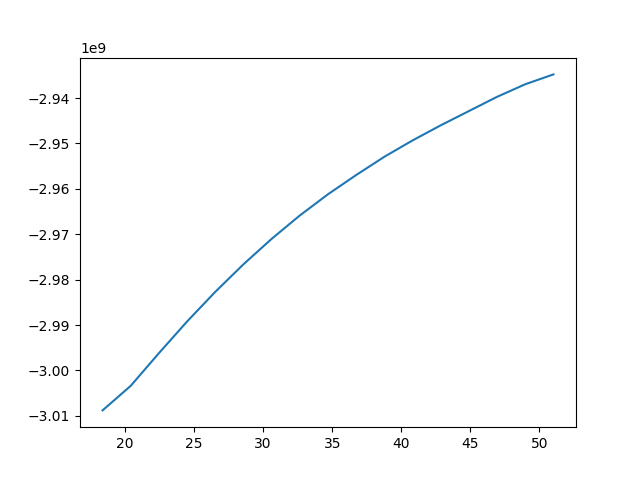

In [21]:
plt.figure()
plt.plot(X[i:j]/reservoir.capacity*100,vb[i:j,s])#-penalties[i:j,s]

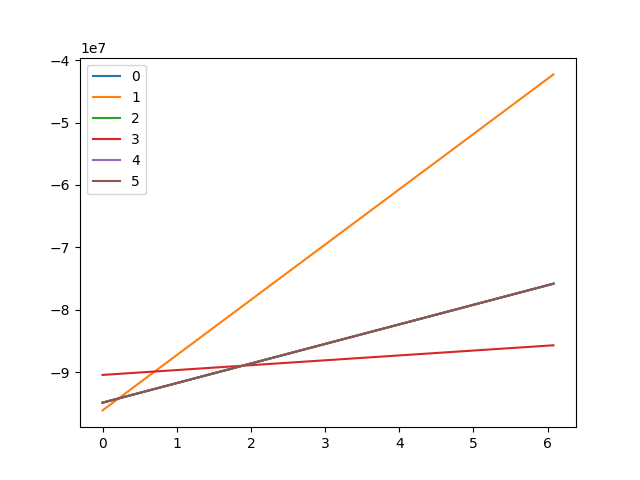

In [22]:
plt.figure()
for k in range(len(G)):
    g = G[k][s,0]*U[s]+G[k][s,1]
    plt.plot(U[s]/reservoir.capacity*100,g,label=f"{k}")#-penalties[i:j,s]
plt.legend()

In [170]:
[G[k][s,:] for k in range(len(G))]

[array([ 1.59989961e+02, -1.38189455e+08]),
 array([ 1.41158368e+01, -1.08215971e+08]),
 array([ 1.41258506e+01, -1.08218965e+08]),
 array([ 1.41258506e+01, -1.08218965e+08]),
 array([ 1.41258506e+01, -1.08218965e+08]),
 array([ 1.41258506e+01, -1.08218965e+08])]